## Sección de Librerías

In [1]:
#Básicos para manipulacion de datos 
import pandas as pd
import numpy as np
#Graficas 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set_theme()
#Optimización multiobjetivo 
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.population import Population

#Finanzas 
import yfinance as yf
import yesg

#Plugins
from tqdm import tqdm
from itertools import compress
from Plugins import pre_processing
from Plugins import ArchievingStrategies
from Plugins import my_plotting
from Plugins import pymoo_extras

## Descarga de lista de activos a escoger
Esta sección puede dar errores si se pierde la conexión, solo es necesario volver a ejecutar. 

In [2]:
assets = pd.read_csv('Indices/tickers_sp500.csv', index_col=0)['0'].tolist()

## Primera parte, obtención de los activos para el portafolio

In [3]:
ohlc = yf.download(assets, period="2y") 
prices = ohlc["Adj Close"].dropna(how="all")

[*********************100%***********************]  503 of 503 completed


In [4]:
prices.tail()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-22,118.680000,16.360001,67.970001,187.000000,137.410004,187.869995,108.250000,72.610001,307.250000,477.579987,...,105.320000,62.759998,103.300003,38.889999,112.430000,136.339996,144.339996,267.910004,26.969999,170.160004
2023-06-23,119.419998,16.260000,65.669998,186.679993,135.919998,187.669998,108.050003,72.410004,298.429993,484.720001,...,104.199997,62.099998,102.400002,38.439999,111.029999,135.600006,143.990005,264.329987,26.600000,168.369995
2023-06-26,118.370003,16.440001,67.290001,185.270004,134.949997,187.759995,108.510002,71.220001,297.410004,479.510010,...,105.250000,62.860001,104.290001,39.310001,110.669998,134.229996,142.809998,273.109985,27.080000,167.539993
2023-06-27,117.040001,17.350000,68.320000,188.059998,132.600006,188.779999,107.790001,71.139999,300.809998,489.269989,...,105.760002,62.439999,104.550003,39.910000,111.610001,134.279999,144.809998,282.809998,27.299999,170.669998
2023-06-28,116.220001,17.370001,67.730003,188.352905,132.820007,189.839996,107.666000,71.525002,300.230011,483.712494,...,104.180000,61.384998,105.290001,39.520000,110.110001,134.779999,144.065002,283.959991,26.930000,169.360001


In [5]:
returns, assets_info= pre_processing.get_assets_info(prices, 99, log_returns=True, drop_per_esg=True)
assets_info #Los rendimientos están con signo al revés 

100%|██████████| 501/501 [01:10<00:00,  7.09it/s]


,exp_risk,exp_return,esg_score
A,0.298801,0.114825,0.152
NWL,0.399629,0.508659,0.137
NVR,0.298743,-0.128615,0.203
NVDA,0.576151,-0.359822,0.134
NUE,0.438669,-0.278623,0.319
...,...,...,...
EQIX,0.308487,0.002374,0.118
EOG,0.404504,-0.212828,0.363
EMR,0.255044,0.008898,0.295
EMN,0.326201,0.140867,0.246


In [6]:
best_assets = ArchievingStrategies.get_best_opt(assets_info.iloc[:, :2], 1e-6)
best_assets

437it [00:00, 24270.54it/s]


,exp_risk,exp_return
PEP,0.167541,-0.139279
ON,0.530952,-0.432498
JNJ,0.160055,-0.022479
MCK,0.219572,-0.392695
ABC,0.212348,-0.265160
HSY,0.186236,-0.200009


In [7]:
fig = my_plotting.plot_assets_plotly(assets_info, best_assets)

## Segunda Parte, Definición del Problema

In [8]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(returns[best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES)

100%|██████████| 6/6 [00:00<00:00,  8.05it/s]


In [9]:
from finquant import efficient_frontier
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
ef_R = ef.efficient_frontier()

## Tercera parte, utilizar distintos muestreos

In [10]:
eps = np.array([0.01,0.01])
colors = ['#7F7F7F', 'rgb(141,160,203)', 'rgb(27,158, 119)']

### Con pesos uniformes

In [12]:
X_das = get_reference_directions("das-dennis", len(PROFITS), n_partitions=12)
F_das, ESG_das = pymoo_extras.eval_weights(portfolio_problem, X_das)
FA_das =  pymoo_extras.annualised_portfolio_quantities(F_das)
FA_das_best = ArchievingStrategies.get_best_opt(FA_das, 1e-6)
FA_das_best_eps = ArchievingStrategies.get_best_opt_eps(FA_das, 1e-6, eps)
print('Total', FA_das.shape)
print('Mejores', FA_das_best.shape)
print('Eps-Mejores', FA_das_best_eps.shape)


6188it [00:00, 21712.51it/s]
6188it [00:01, 4756.36it/s]

Total (6188, 2)
Mejores (82, 2)
Eps-Mejores (2403, 2)


In [13]:
frames = [FA_das, FA_das_best_eps, FA_das_best]
labels = ['All (Das-Dennis)', 'PQ-eps', 'PQ']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)

### Con Algoritmos Evolutivos

In [14]:
from pymoo.termination import get_termination
termination = get_termination("n_gen", 300)
from pymoo.algorithms.moo.nsga2 import NSGA2
nsgaii = NSGA2(pop_size=20,repair=pymoo_extras.Portfolio_Repair())
from pymoo.algorithms.moo.sms import SMSEMOA
smsemoa = SMSEMOA(pop_size=20, repair=pymoo_extras.Portfolio_Repair())

#### Con NSGA-II

In [15]:
X_nsgaii, F_nsgaii, ESG_nsgaii =pymoo_extras.get_weights_with_pymoo(portfolio_problem, nsgaii, termination)
FA_nsgaii =  pymoo_extras.annualised_portfolio_quantities(F_nsgaii)
FA_nsgaii_best = ArchievingStrategies.get_best_opt(FA_nsgaii, 1e-6)
FA_nsgaii_best_eps = ArchievingStrategies.get_best_opt_eps(FA_nsgaii, 1e-6, eps)
print('Total', FA_nsgaii.shape)
print('Mejores', FA_nsgaii_best.shape)
print('Eps-Mejores', FA_nsgaii_best_eps.shape)

6000it [00:00, 10816.17it/s]
6000it [00:02, 2269.10it/s]

Total (6000, 2)
Mejores (732, 2)
Eps-Mejores (4597, 2)


In [16]:
frames = [FA_nsgaii, FA_nsgaii_best_eps, FA_nsgaii_best]
labels = ['All (NSGA-II)', 'PQ-eps', 'PQ']
fig=my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)

#### Con SMS-EMOA

In [17]:
X_smsemoa, F_smsemoa, ESG_smsemoa =pymoo_extras.get_weights_with_pymoo(portfolio_problem, smsemoa, termination)
FA_smsemoa =  pymoo_extras.annualised_portfolio_quantities(F_smsemoa)
FA_smsemoa_best = ArchievingStrategies.get_best_opt(FA_smsemoa, 1e-6)
FA_smsemoa_best_eps = ArchievingStrategies.get_best_opt_eps(FA_smsemoa, 1e-6, eps)
print('Total', FA_smsemoa.shape)
print('Mejores', FA_smsemoa_best.shape)
print('Eps-Mejores', FA_smsemoa_best_eps.shape)

6000it [00:00, 7528.00it/s] 
6000it [00:03, 1755.63it/s]

Total (6000, 2)
Mejores (1422, 2)
Eps-Mejores (4937, 2)


In [18]:
frames = [FA_smsemoa, FA_smsemoa_best_eps, FA_smsemoa_best]
labels = ['All (SMS-EMOA)', 'PQ-eps', 'PQ']
fig=my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)

## Evaluación 

In [19]:
from pymoo.indicators.hv import HV
from pymoo.indicators.igd import IGD
from pymoo.indicators.gd import GD
from sklearn.preprocessing import MinMaxScaler
def get_pfa(name,  parameter): 
    if name=='das-dennis':
        X_ = get_reference_directions("das-dennis", len(PROFITS), n_partitions=parameter)
        F_, ESG_ = pymoo_extras.eval_weights(portfolio_problem, X_das)
    else: 
        X_, F_, ESG_ =pymoo_extras.get_weights_with_pymoo(portfolio_problem, parameter, termination)
    FA_ = pymoo_extras.annualised_portfolio_quantities(F_)
    FA_best = ArchievingStrategies.get_best_opt(FA_, 1e-6)
    return FA_best.to_numpy()

def invert_sign(list_pfa): 
    L = []
    for s in list_pfa:
        s1 = s.copy()
        s1[:, 1] = -s1[:,1]
        L.append(s1)   
    return L  

def eval_GD(pf, list_pfa):  
    ind = GD(pf)
    list_p = invert_sign(list_pfa)
    return [ind(A) for A in list_p]   

def eval_IGD(pf, list_pfa): 
    ind = IGD(pf)
    list_p = invert_sign(list_pfa)
    return [ind(A) for A in list_p]  

def eval_HV(ref_point, list_pfa): 
    scaler = MinMaxScaler()
    Ftest = np.vstack(list_pfa)
    scaler.fit(Ftest)
    ind = HV(ref_point=ref_point)
    return [ind(scaler.transform(A)) for A in list_pfa]

algs = { 'das-dennis': 12, 'nsgaii': nsgaii, 'sms-emoa':smsemoa}

def full_evaluation(iters, algs, pf, ref_point):
    metric_eval = {'GD': [], 'IGD': [], 'HV': []}
    metrics = {'GD': lambda x: eval_GD(pf, x), 
               'IGD':lambda x: eval_IGD(pf, x), 
               'HV': lambda x: eval_HV(ref_point, x)}
    for i in range(iters): 
        results = [ get_pfa(name, par) for name, par in algs.items()]
        for indicator in metrics.keys(): 
            metric_eval[indicator].append(metrics[indicator](results[:]))
    
    metric_eval_means = {}
    for indicator in metric_eval.keys(): 
        metric_eval_means[indicator]=np.mean( np.array(metric_eval[indicator]), axis=0)
    
    return pd.DataFrame(metric_eval_means, index = algs.keys())
     


In [20]:
evaluation = full_evaluation(10, algs, ef_R, np.array([1.1,1.1]))
evaluation

6188it [00:00, 21544.57it/s]
6000it [00:00, 13004.82it/s]
6000it [00:00, 8823.58it/s] 
6188it [00:00, 32361.39it/s]
6000it [00:00, 11976.10it/s]
6000it [00:00, 7490.66it/s] 
6188it [00:00, 19157.86it/s]
6000it [00:00, 13177.47it/s]
6000it [00:00, 6016.29it/s] 
6188it [00:00, 24653.84it/s]
6000it [00:00, 11560.74it/s]
6000it [00:00, 7532.18it/s] 
6188it [00:00, 30632.59it/s]
6000it [00:00, 12043.32it/s]
6000it [00:00, 7042.23it/s] 
6188it [00:00, 19337.68it/s]
6000it [00:00, 11173.15it/s]
6000it [00:00, 7407.34it/s] 
6188it [00:00, 21865.41it/s]
6000it [00:00, 11342.19it/s]
6000it [00:00, 7121.68it/s] 
6188it [00:00, 24851.99it/s]
6000it [00:00, 14126.73it/s]
6000it [00:00, 7545.40it/s] 
6188it [00:00, 27381.27it/s]
6000it [00:00, 11237.79it/s]
6000it [00:00, 8059.44it/s] 
6188it [00:00, 27711.39it/s]
6000it [00:00, 8379.81it/s] 
6000it [00:00, 7892.62it/s] 


,GD,IGD,HV
das-dennis,0.003170,0.017436,1.089452
nsgaii,0.006565,0.017237,1.097160
sms-emoa,0.003769,0.017012,1.097656


## Gráficas de Interés Muestreo Ganador

In [21]:
X, F, ESG =pymoo_extras.get_weights_with_pymoo(portfolio_problem,smsemoa, termination)
FA =  pymoo_extras.annualised_portfolio_quantities(F)
FA_best = ArchievingStrategies.get_best_opt(FA, 1e-6)
FA_best_eps = ArchievingStrategies.get_best_opt_eps(FA, 1e-6, eps)

FA_3D = FA_best_eps.copy()
FA_3D['exp_esg'] = ESG[FA_best_eps.index]
FA_3D_best       = ArchievingStrategies.get_best_opt(FA_3D, 1e-6)

print('Total', FA.shape)
print('Mejores', FA_best.shape)
print('Eps-Mejores', FA_best_eps.shape)
print('Mejores 3D', FA_3D_best.shape)

6000it [00:00, 10101.04it/s]
6000it [00:03, 1610.61it/s]
5449it [00:01, 4327.55it/s]

Total (6000, 2)
Mejores (1174, 2)
Eps-Mejores (5449, 2)
Mejores 3D (2209, 3)


In [23]:
frames = [FA, FA_best_eps, FA_best]
labels = ['All (SMS-EMOA)', 'PQ-eps', 'PQ']
colors = ['#7F7F7F', 'rgb(141,160,203)', 'rgb(27,158, 119)']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)

In [32]:
## Correciones de signos 
#En dos objetivos
FA_best['exp_return'] = -FA_best['exp_return']
FA_best['exp_esg'] =  ESG[FA_best.index] 
#En tres objetivos
FA_3D_best['exp_return'] = - FA_3D_best['exp_return']
FA_3D['exp_return'] = - FA_3D['exp_return']
FA_3D['Type'] = 'PQ-eps 2obj'
FA_3D.loc[FA_3D_best.index, 'Type']='PQ 3obj'

In [33]:
fig = px.scatter_3d(FA_3D.sort_values(by='Type'), x='exp_risk', y='exp_return', z='exp_esg',
                color_discrete_sequence=['rgb(27,158, 119)','rgb(141,160,203)'],
                color='Type', width=800, height=800, 
                labels = {'exp_risk':'Riesgo Anual Esperado', 
                          'exp_return': 'Retorno Anual Esperado', 
                          'exp_esg': 'ESG score'})
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
)
fig.show()

In [34]:
fig = px.scatter(FA_3D_best, x='exp_risk', y='exp_return', color='exp_esg',
                 labels = {'exp_risk':'Riesgo Anual Esperado', 
                          'exp_return': 'Retorno Anual Esperado', 
                          'exp_esg': 'ESG score'})
fig.add_trace(go.Scatter(x=ef_R[:,0], y=ef_R[:,1],
                    mode='lines',
                    name='Markowitz', 
                    marker_color='#222A2A'), 
                 )
fig.update_layout(coloraxis_colorbar_y=0.45)
fig.show()

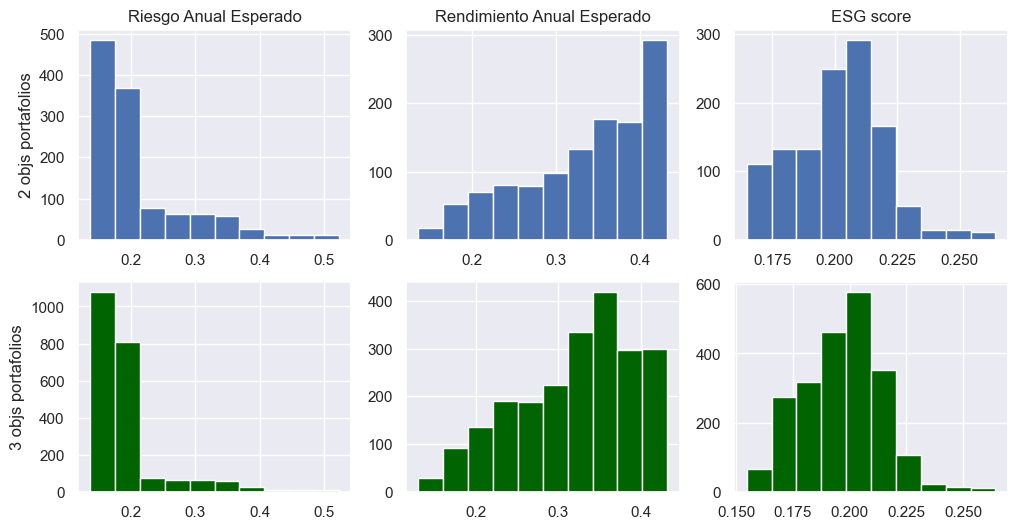

In [35]:
fig, ax = plt.subplots(2,3, figsize= (12,6))
ax[0][0].set_ylabel('2 objs portafolios')
ax[1][0].set_ylabel('3 objs portafolios')
ax[0][0].set_title('Riesgo Anual Esperado')
ax[0][1].set_title('Rendimiento Anual Esperado')
ax[0][2].set_title('ESG score')
for i in range(3): 
    FA_best.iloc[:, i].hist(ax=ax[0][i])
    FA_3D_best.iloc[:, i].hist(ax=ax[1][i], color='darkgreen')


In [36]:
X_best = X[FA_best.index]
X_3D_best = X[FA_3D_best.index]
X_best_means = np.mean(X_best, axis=0)
X_3D_best_means = np.mean(X_3D_best, axis=0)


In [37]:
assets_proportion = assets_info.loc[best_assets.index]
assets_proportion['Aportación 2obj']= X_best_means 
assets_proportion['Aportación 3obj']= X_3D_best_means

Text(0.5, 1.0, 'Composición de Portafolios 3 objs')

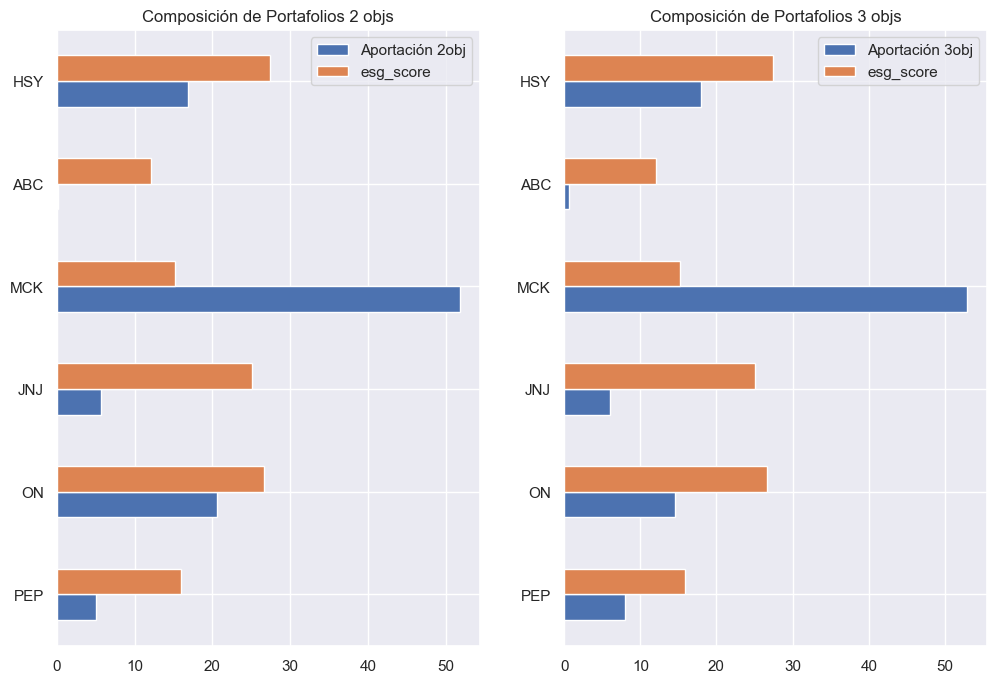

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))
(assets_proportion[['Aportación 2obj','esg_score']]*100).plot(kind='barh', ax=ax[0])
(assets_proportion[['Aportación 3obj','esg_score']]*100).plot(kind='barh', ax=ax[1])
ax[0].set_title('Composición de Portafolios 2 objs')
ax[1].set_title('Composición de Portafolios 3 objs')